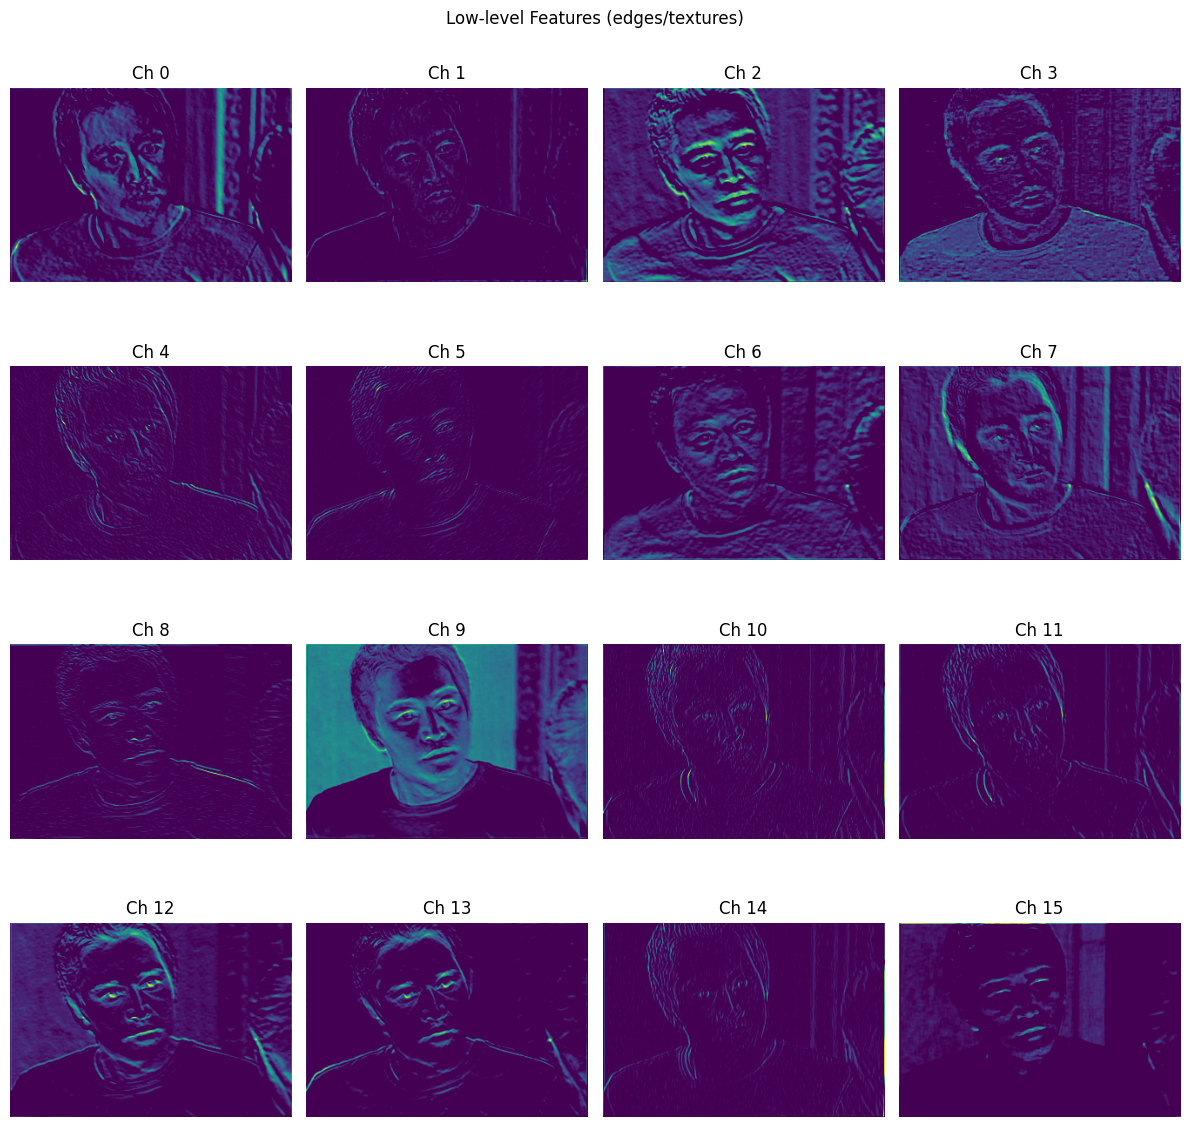

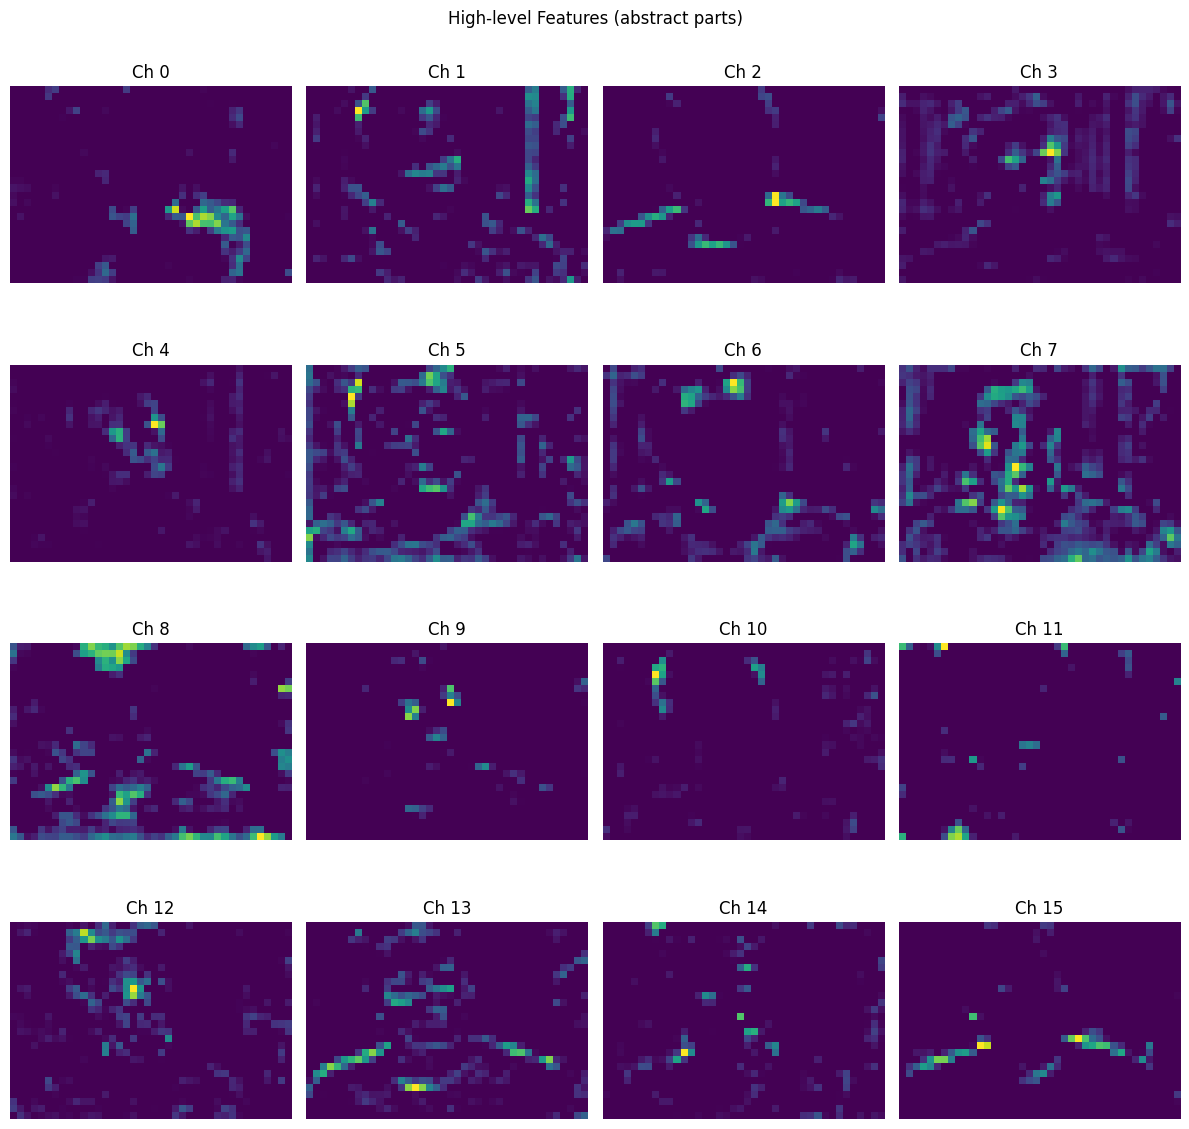

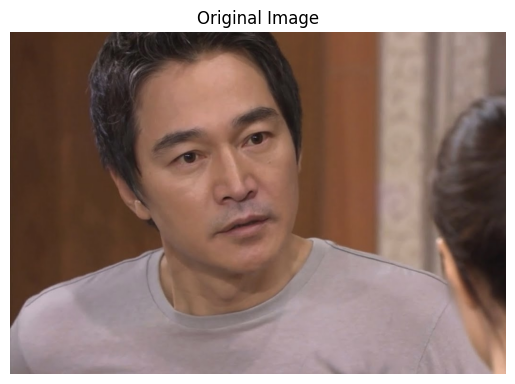

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# 1. 이미지 준비 및 전처리
img_path = './nst_practice/IMG_7258.jpg'  # 시각화할 이미지 경로
img = Image.open(img_path).convert('RGB')

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_tensor = transform(img).unsqueeze(0)  # (1, 3, 224, 224)

# 2. VGG16 모델 불러오기 (pretrained)
model = torchvision.models.vgg16(weights="VGG16_Weights.DEFAULT")
model.eval()

# 3. Feature map 추출을 위한 hook 함수 정의
feature_maps = {}

def get_activation(name):
    def hook(model, input, output):
        feature_maps[name] = output.detach()
    return hook

# 4. Low-level, High-level 레이어 선택 및 hook 등록
# VGG16의 features[0]~[3]: low-level, features[28]: high-level (마지막 conv)
layer_names = {
    'low_level': model.features[3],   # Conv2 (features[3])
    'high_level': model.features[18], # Conv13 (features[28])
}
for name, layer in layer_names.items():
    layer.register_forward_hook(get_activation(name))

# 5. Forward pass (feature map 추출)
with torch.no_grad():
    _ = model(input_tensor)

# 6. Feature map 시각화 함수
def plot_feature_maps(fmap, max_channels=16, title=''):
    fmap = fmap.squeeze(0).cpu().numpy()  # (C, H, W)
    num_channels = min(fmap.shape[0], max_channels)
    n_cols = 4
    n_rows = int(np.ceil(num_channels / n_cols))
    plt.figure(figsize=(n_cols*3, n_rows*3))
    for i in range(num_channels):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(fmap[i], cmap='viridis')
        plt.axis('off')
        plt.title(f'Ch {i}')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# 7. Low-level feature map 시각화
plot_feature_maps(feature_maps['low_level'], max_channels=16, title='Low-level Features (edges/textures)')

# 8. High-level feature map 시각화
plot_feature_maps(feature_maps['high_level'], max_channels=16, title='High-level Features (abstract parts)')

# 9. 원본 이미지도 같이 출력
plt.figure()
plt.imshow(np.asarray(img))
plt.title('Original Image')
plt.axis('off')
plt.show()
